## Calculating return period for cyclones in Madagascar


Using their Database

In [39]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import os
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [41]:
AA_DATA_DIR = os.getenv("AA_DATA_DIR")

In [42]:
cyclone_db = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cyclone_database"
    / "Synthèse dégâts Climatiques 1997 - 2024 (OCHA).xlsx"
)
cyclone_db = pd.read_excel(cyclone_db, sheet_name="BDD").dropna(how="all")

In [43]:
cyclone_db["Categorie"].unique()

array(['Cyclone tropical', 'ZCIT', 'tempete tropicale',
       'Tempete tropicale', 'cyclone Tropical intense',
       'Perturbation tropicale', 'Forte tempete tropicale',
       'Cyclone tropical tres intense', 'Tempete tropicale Moderee',
       'Fortes pluies', 'Depression tropicale',
       'Depression tropicale Moderee', 'cyclone tropicale Moderee',
       'Cyclone tropical ', nan], dtype=object)

Total storms of intensity 'Tropical Cyclone' or higher: 30
Return period (years between events): 0.9333333333333333


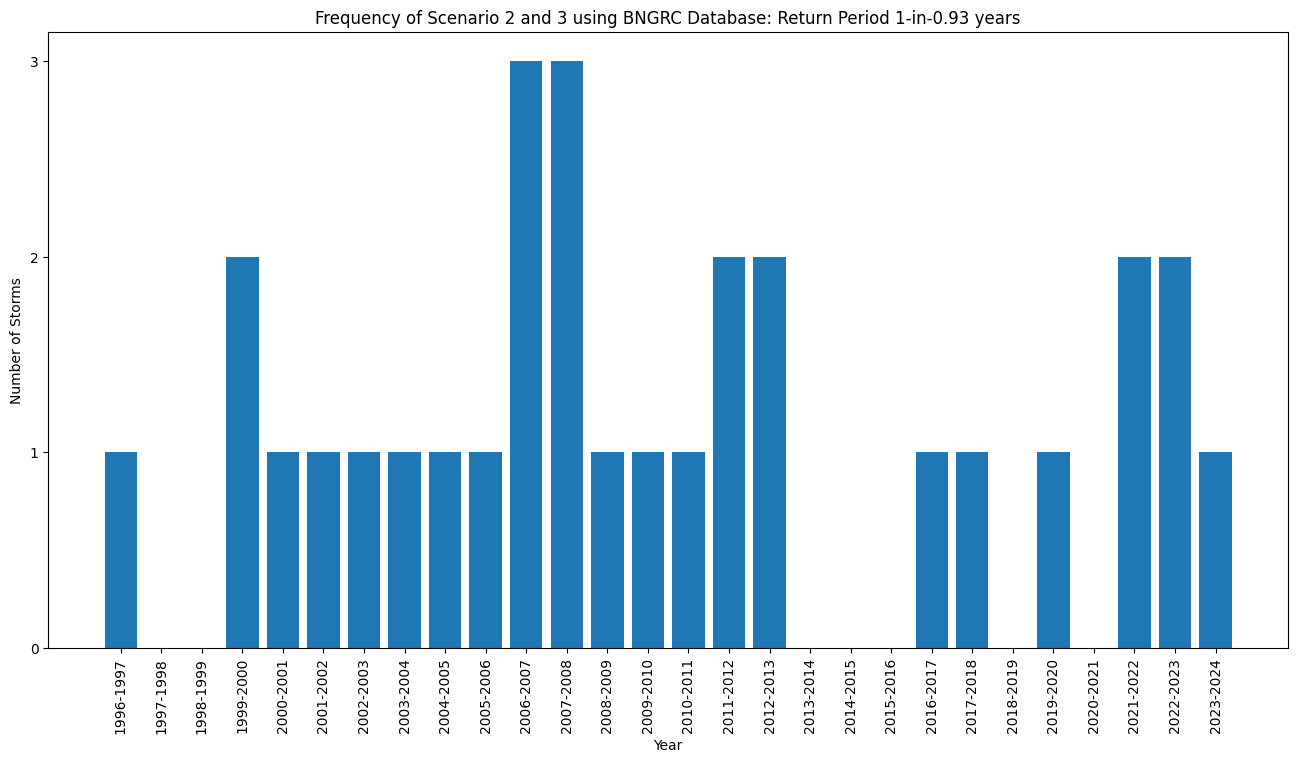

In [87]:
intense_storms = cyclone_db[
    cyclone_db["Categorie"].isin(
        [
            "Cyclone tropical",
            "cyclone Tropical intense",
            "Cyclone tropical tres intense",
            "Cyclone tropical ",
        ]
    )
]

# Generate a list of seasons from 1996/1997 to 2023/2024
start_years = range(1996, 2024)  # 1996 to 2023 as start years
seasons = [f"{year}-{year + 1}" for year in start_years]

# Create a DataFrame with all possible seasons
all_seasons = pd.DataFrame({"Saison": seasons})

# Count the number of intense storms per season
storm_frequency_per_year = (
    intense_storms.groupby("Saison")["Nom"]
    .nunique()
    .reset_index(name="Storm_Count")
)
# Merge with all_seasons to ensure all years are included
storm_frequency_per_year = pd.merge(
    all_seasons, storm_frequency_per_year, on="Saison", how="left"
).fillna(0)

# Calculate the overall return period (frequency) by dividing the total number of years by the total storms
total_years = all_seasons.shape[0]
total_storms = intense_storms["Nom"].nunique()
return_period = total_years / total_storms

# Display results
print("Total storms of intensity 'Tropical Cyclone' or higher:", total_storms)
print("Return period (years between events):", return_period)
plt.figure(figsize=(16, 8))
plt.bar(
    storm_frequency_per_year["Saison"],
    storm_frequency_per_year["Storm_Count"],
)
plt.xticks(rotation=90)
# Set y-axis to show only integers
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("Year")
plt.ylabel("Number of Storms")
plt.title(
    f"Frequency of Scenario 2 and 3 using BNGRC Database: Return Period 1-in-{round(return_period, 2)} years"
)
plt.show()

Total storms of intensity 'Intense Tropical Cyclone' or higher: 8
Return period (years between events): 3.5


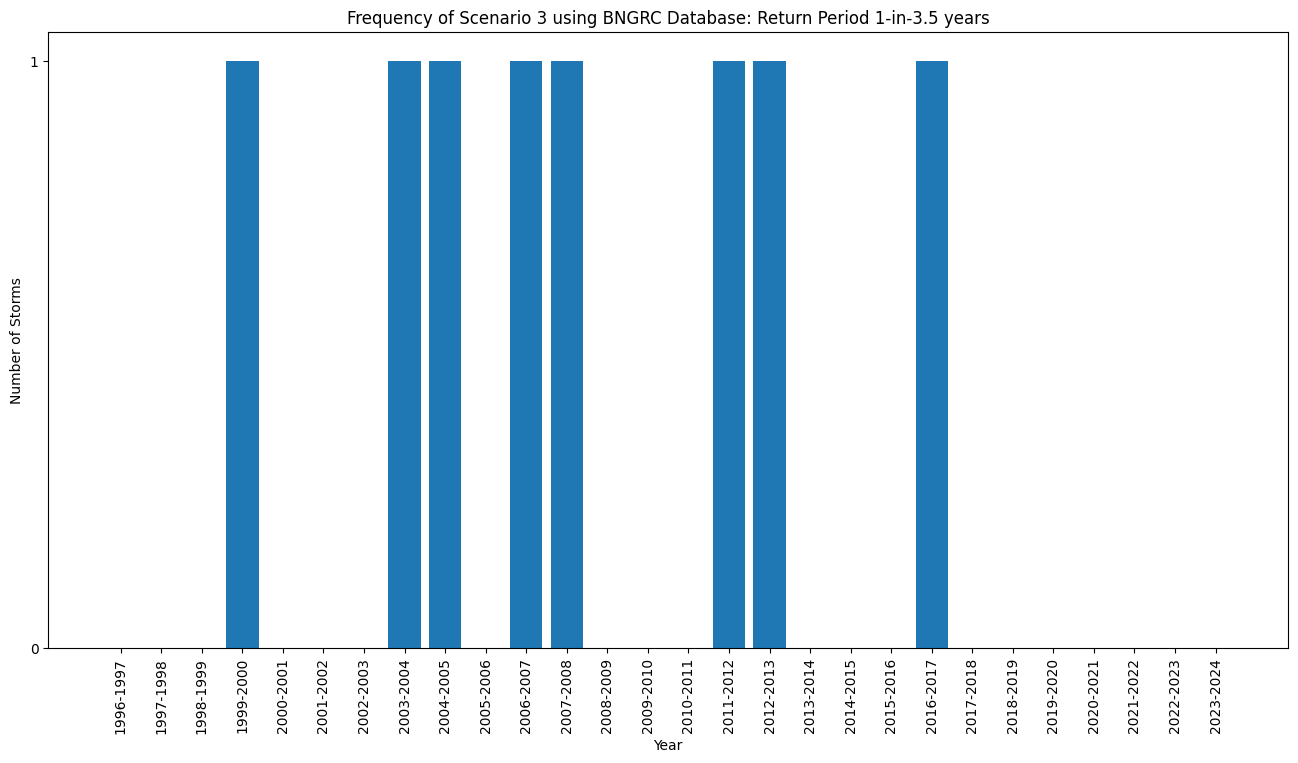

In [89]:
intense_storms = cyclone_db[
    cyclone_db["Categorie"].isin(
        [
            "cyclone Tropical intense",
            "Cyclone tropical tres intense",
        ]
    )
]

# Generate a list of seasons from 1996/1997 to 2023/2024
start_years = range(1996, 2024)  # 1996 to 2023 as start years
seasons = [f"{year}-{year + 1}" for year in start_years]

# Create a DataFrame with all possible seasons
all_seasons = pd.DataFrame({"Saison": seasons})

# Count the number of intense storms per season
storm_frequency_per_year = (
    intense_storms.groupby("Saison")["Nom"]
    .nunique()
    .reset_index(name="Storm_Count")
)
# Merge with all_seasons to ensure all years are included
storm_frequency_per_year = pd.merge(
    all_seasons, storm_frequency_per_year, on="Saison", how="left"
).fillna(0)

# Calculate the overall return period (frequency) by dividing the total number of years by the total storms
total_years = all_seasons.shape[0]
total_storms = intense_storms["Nom"].nunique()
return_period = total_years / total_storms

# Display results
print(
    "Total storms of intensity 'Intense Tropical Cyclone' or higher:",
    total_storms,
)
print("Return period (years between events):", return_period)
plt.figure(figsize=(16, 8))
plt.bar(
    storm_frequency_per_year["Saison"],
    storm_frequency_per_year["Storm_Count"],
)
plt.xticks(rotation=90)
# Set y-axis to show only integers
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("Year")
plt.ylabel("Number of Storms")
plt.title(
    f"Frequency of Scenario 3 using BNGRC Database: Return Period 1-in-{return_period} years"
)
plt.show()